In [2]:
from slimstampen.spacingmodel import SpacingModel, Fact, Response
import matplotlib.pyplot as plt 
from numpy import pi, sqrt, exp, log, e, Infinity
import numpy as np
import random as r
from memory import memory
from scipy.stats import logistic
from matplotlib.ticker import PercentFormatter


In [3]:
#Need to create a timeline for each memory lab to go for
    #How long should each one be?
    #First need to set up response time determination and correct response determination


#Returns a random activation based off of the determinstic eq and the logistic distribution of activation.
# m: Memory to calculate random activation of
# t: time in which activation will be measured
def noise_actv(m, t):
    sd = pi * m.get_s()/ sqrt(3)
    noisedist = logistic(m.get_actv(t), sd)
    new_actv = noisedist.rvs()
    return new_actv

#Returns aresponse time based off of the deterministic eq for response time and activation
#actv: Activation of memory
#t0: Reaction time buffer, basically the minimum resposnse time
def rst(actv, t0):
    return t0 + (e ** (- actv))


#Returns a true or false response based off the activation, the s parameter, and our determined activation threshold (What is the actv thresh?)
def get_response(actv, s, thresh):
    prob = 1 / (1 + e ** (-(actv - thresh) / s))
    resp = r.uniform(0, 1) <= prob
    return resp



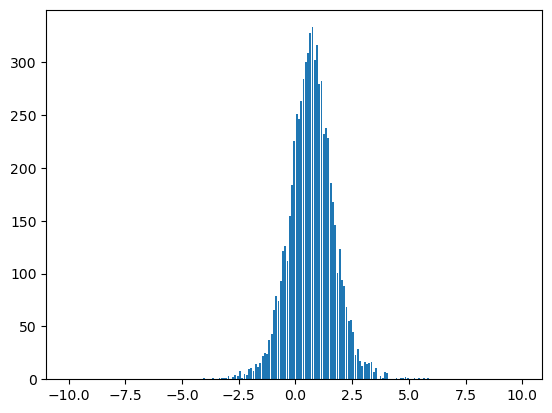

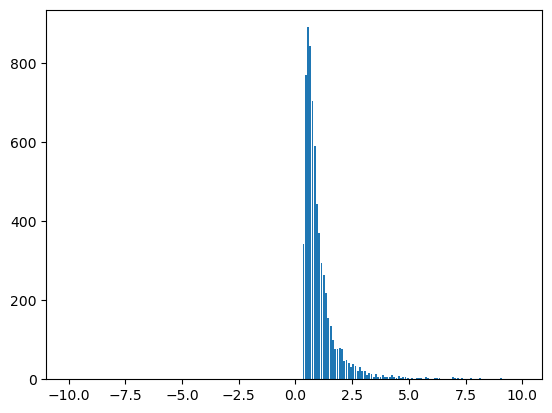

0.6230822226174448
1.0559952767736007
0.8611009507481124
0.5292685403410906
0.8462740340644808
1.4180435360530985
0.3294942837528208
0.6324008242050161
0.6216874054866341
2.6810461869974596


In [4]:
#Testing out Methods do not worry about this block

m = memory(0.3, 0.25, 0.3)
m.add_trace(0)
t = []

for _ in range(7000):
    t.append(noise_actv(m, 0.1))

a = plt.hist(t, [x / 10 for x in range(-100, 100)], rwidth=0.8)
plt.show()


t = [rst(x, t0=0.3) for x in t]

a = plt.hist(t, [x / 10 for x in range(-100, 100)], rwidth=0.8)
plt.show()

for x in range(10):
    print(t[x])

In [5]:
#Next, need to create facts that can be tested against, and have teh thing predict my alpha/sof
#please remember the 600 ms buffer as well as the reaction time buffer. so, every new question should increase time by 600ms at start
# not even considering reaction time

#could just start with time 0 at every
SIM_END_TIME = 12 #minutes
FORGET_THRESHOLD = -0.8
NUM_FACTS = 20
sof = 0.3
SPC = 0.25
S = 0.1
F = 1 
t0 = 0.3

q_buff = 0.6


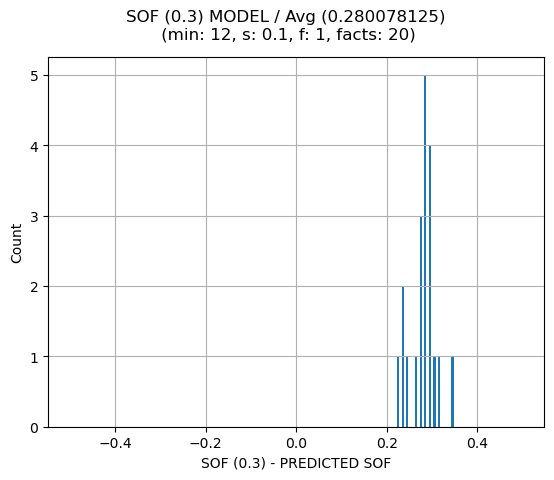

In [6]:
#remember that model for get_next_fact returns true if fact is new and hasnt been presented

#also need to remember to add memory traces whenever a new fact is presented, and the 4000 milli dif of incorrect answer,
#600 ms block spacing otherwise

#DEBUG 7/3/24: Bro so I just realized rst was in milliseconds for spacing model, but I am using and passing seconds. So
#I have been passing 1/1000 of what I should of been for response time. This change was noticed as activation was wayyy
#too high. Going to try and fix by multiplying my values by 1000 (time and resp time)

"Taking in an SOF, simulates model with that sof in a memory lab test, and returns the estimated sof for each fact"
def simulate(SOF):
    t = 0
    sm = SpacingModel()

    memories = []

    for x in range(NUM_FACTS):
        fact = Fact(x, "q", "q")
        sm.add_fact(fact)
        memories.append(memory(SOF, SPC, s=S, F=F))

    while t <= SIM_END_TIME * 60:
        fact, new = sm.get_next_fact(t * 1000)

        if new:
            #IF FACT IS NEW, ADD CREATE FACT MEMORY, PLEASE ASK ANDREA ABOUT THIS
            #Okay so the way its currently set up, I get -infinity when t = encoding time, but should be infinity at that time no?
            #Im gonna do it ask andrea abti it l8r
            
            fact_id = fact.fact_id
            memories[fact_id].add_trace(t)
            actv = Infinity                         #PLEASSE COME BACK TO THIS
            corr = get_response(actv, S, FORGET_THRESHOLD)
            rst = rst(actv, t0) # for milliseconds

            t += rst

            resp = Response(fact, t * 1000, rst * 1000, corr)
            sm.register_response(resp)

            t += q_buff

        else:
            fact_id = fact[0]
            actv = noise_actv(memories[fact_id], t)
            corr = get_response(actv, S, FORGET_THRESHOLD)
            rst = rst(actv, t0)

            resp = Response(fact, t * 1000, rst * 1000, corr)
            sm.register_response(resp)

            t += rst
            memories[fact_id].add_trace(t)
            
            if corr:
                t += q_buff
            else:
                t += 4
    
    sof = []
    for x in range(NUM_FACTS):
        sof.append(sm.get_rate_of_forgetting(t * 1000, sm.facts[x]))

    return sof

sofs = []

for x in range(1):
    sofs.extend(simulate(sof))

plt.hist(sofs, 100, [-1/2, 1/2], rwidth = 0.5)

plt.suptitle(f"SOF ({sof}) MODEL / Avg ({sum(sofs)/len(sofs)}) \n (min: {SIM_END_TIME}, s: {S}, f: {F}, facts: {NUM_FACTS}) ")
plt.grid(True)
plt.xlabel(f"SOF ({sof}) - PREDICTED SOF")
plt.ylabel("Count")


plt.show()

KeyboardInterrupt: 

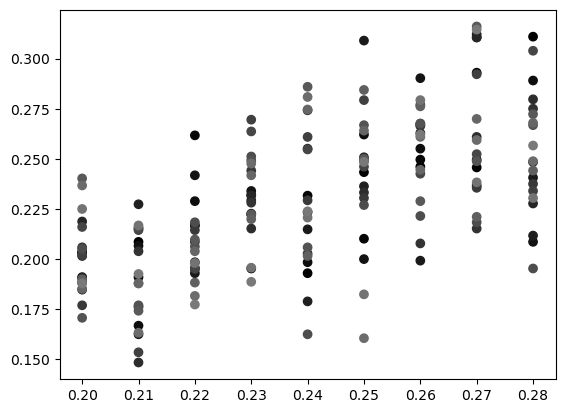

In [7]:
#Darker is older, lighter is newer

msofs = [x / 100 for x in range(20, 50)]
sofs = []

colors = [f"{x / (NUM_FACTS * 2)}" for x in range(0, NUM_FACTS)]

for s in [0.05, 0.1, 0.2, 0.3]:
    for msof in msofs:
        sofs = simulate(msof)
        plt.scatter([msof for _ in range(len(sofs))], sofs, c=colors )

    print(len(sofs))
    plt.suptitle(f"SOF Parameter Recovery (S: {S}, F: {F}, SimT:{SIM_END_TIME}, #Facts:{NUM_FACTS})\n(Dark: Earlier Fact, Light: Later Fact)")
    plt.xlabel("\"SUBJECT\" SOF")
    plt.ylabel("Memory Lab SOF")
    plt.plot(msofs,msofs,"r--")

    plt.show()

